In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image, ImageDraw
from time import localtime, strftime

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 7)

# Number of samples in each class

TEST_SAMPLE_NUMBER = 51731
TRAIN_SAMPLE_NUMBER = 257187

In [2]:
ZERO_PADDING = 6

def get_filename(index):
    return "src/Csv/{}.txt".format(str(index).zfill(ZERO_PADDING))

def get_framename(index):
    return "src/Frame/{}.jpg".format(str(index).zfill(ZERO_PADDING))

NUMBER_OF_PEDESTRIANS = 12273

def download_pedestrian(index):
    assert(0 <= index < NUMBER_OF_PEDESTRIANS), "pedestrian number should be between 0 and {max}; given number: {id}".format(
        max=NUMBER_OF_PEDESTRIANS-1, id=index)
    filename = get_filename(index)
    data = pd.read_csv(filename, index_col=0)
    return data

In [3]:
def make_view(data, length, only_odd_rows=True):
    data = np.array(data).flatten()
    len1 = len(data)
    len2 = length
    return np.lib.stride_tricks.as_strided(data, shape=(len1 - len2 + 1, len2),
                                                    strides=(data.dtype.itemsize,) * 2)[::2 if only_odd_rows else 1, :]

In [4]:
# array1: [sX1; sY1; sX2; sY2; ...]
# array2: [eX1; eY1; eX2; eY2; ...]
# output: [dist((sX1, sY1), (eX1, eY1)), dist((sX1, sY1), (eX1, eY1)),
#          dist((sX2, sY2), (eX2, eY2)), dist((sX2, sY2), (eX2, eY2)), ...]

def distance_for_each_point(array1, array2):
    array_length = len(array1)
    len2 = len(array2)
    assert (array_length == len2), "Arrays' sizes have to be equal (array1: {}, array2: {})".format(array_length, len2)
    
    if array1.ndim == 1:
        distance = np.linalg.norm((array1 - array2).reshape((int(array_length / 2), 2)), axis=1)
        result = np.array([[d, d] for d in distance]).flatten()
    else:
        result = np.array([distance_for_each_point(array1[i], array2[i]) for i in range(array_length)])
    
    return result

# metrics between real results (in tests) and predicted
def distance(test_results, predicted_results):
    return distance_for_each_point(np.array(test_results), predicted_results).sum() / TEST_SAMPLE_NUMBER / 2

# score between real results (in tests) and predicted
def score(test_results, predicted_results, baseline_results):
    test_results = np.array(test_results)
    predicted_results = np.array(predicted_results)
    baseline_results = np.array(baseline_results)
    return (1 - ((test_results - predicted_results) ** 2).sum()/((test_results - baseline_results) ** 2).sum())

In [35]:
# data may be present as [n_features * n_samples] or [n_samples * n_features] 
# usually algorithms require second variant but I prefer first

def to_model(df):
    df = np.array(df)
    return df.T.reshape((int(df.shape[1] / 2), int(df.shape[0] * 2)))

def to_model_with_features(df):
    df = np.array(df)
    movement_vector = np.diff(df,axis=0)
    tmp = np.power(movement_vector, 2)
    tmp[:,::2] = -tmp[:,::2]
    tmp = np.sqrt(np.diff(tmp)[:,::2])
    last_speed = tmp[-1:]
    tmp = np.mean(tmp, axis=0)
    return (np.concatenate((to_model(df), to_model(movement_vector), np.array(last_speed).T, np.array([tmp]).T),
                           axis=1)).astype(int)
def from_model(npa):
    return npa.reshape((int(npa.shape[1] / 2), int(npa.shape[0] * 2))).T

In [6]:
# first simply algorithm to get some start
# more about it you can find in 'baseline_distance_between_real_points_and_predicted.ipynb'
def baseline(test_data, start_point_index=0, number_of_points_to_return=5):
    error_template = "Start point index should be less than last point. Start point index: {st}, last point index: {end}"
    assert (start_point_index < len(test_data) - 1), error_template.format(st=start_point_index, end=len(test_data) - 1)
    
    start_point = np.array(test_data)[start_point_index]
    last_but_one_point = np.array(test_data)[-2]
    end_point = np.array(test_data)[-1]
    
    distance = distance_for_each_point(end_point, start_point)
    normalized_motion_vector = (end_point - start_point) / distance
    normalized_motion_vector[np.where(distance == 0)] = 0
    last_vector_length = distance_for_each_point(end_point, last_but_one_point)
    
    motion_vector = normalized_motion_vector * last_vector_length
    result = []
    for i in range(number_of_points_to_return):
        result.append(end_point + (i + 1) * motion_vector)
        
    return np.array(result)

You need to pass as arguments function to execute, test_results to compare with predicted by function, parameter_name to know results by which parameter you want to compare and list_of_values for this parameter.

Also you need to pass other argument which function will use it's always some test_data and usually train_data and train_results.

In [7]:
def compare_results(function, test_results, parameter_name, list_of_values, **other_parameters):
    result = [] # we will keep results for each configuration here

    for i, value in enumerate(list_of_values):
        print("{cur}/{num}: {t}".format(cur=i+1, num=len(list_of_values), t=strftime("%Y-%m-%d %H:%M:%S", localtime())))
        other_parameters[parameter_name] = value        
        predicted_results = function(**other_parameters)
        np.save("src/Logs/{date}_predicted_coordinates_{function_name}_{parameter_name}_".format(
                date=strftime("%Y%m%d", localtime()), function_name=function.__name__, parameter_name=parameter_name)
                + str(value), predicted_results)
        result.append(score(test_results, predicted_results, baseline(other_parameters['test_data'], start_point_index=2)))
        
    print("done! {time}".format(time=strftime("%Y-%m-%d %H:%M:%S", localtime())))
    print("Results: {}".format(result))
        
    ind = list_of_values
    number = len(ind)
    width = 2 / number
    result_bar = plt.bar(range(number), result, width, color='g')

    plt.ylabel('Average difference')
    plt.xlabel(parameter_name)
    plt.title("Difference between real points and predicted by {parameter_name} in {function_name}".format(
        function_name=function.__name__, parameter_name=parameter_name))
    plt.xticks(np.array(range(number)) + width/2, ind)
    plt.savefig("src/Plots/{date}_{function_name}_score_by_{parameter_name}_with_features.png".format(
        date=strftime("%Y%m%d", localtime()), function_name=function.__name__, parameter_name=parameter_name))    

In [8]:
def draw_lines(frame_number, paths, colors, image_name, draw_line=True):
    im = Image.open(get_framename(frame_number))
    draw = ImageDraw.Draw(im)
    for path, color in zip(paths, colors):
        if draw_line:
            path_view = make_view(path, 4)
            for line in path_view:
                draw.line(tuple(line), width=4, fill=color)
        else:
            for point in path:
                draw.ellipse(tuple(np.append(point, point+10)), fill=color)

    im.save("src/Images/{name}.jpg".format(name=image_name))

In [9]:
def find_by_path(path, search_in_test=True):
    
    indices = np.arange(NUMBER_OF_PEDESTRIANS)
    if search_in_test:
        pedestrian_separation = pd.read_csv('src/pedestrian_labels_and_test_and_train_separation.csv', index_col=0)
        indices = np.where(np.array(pedestrian_separation['category']) == 'test')[0]
        
    path = path.flatten()    
    len2 = len(path)
        
    for i in indices:
        df = download_pedestrian(i)
        data = np.array(df).flatten()
        len1 = len(data)
        data_view = np.lib.stride_tricks.as_strided(data, shape=(len1 - len2 + 1, len2),
                                                    strides=(data.dtype.itemsize,) * 2)[::2, :]
        
        ind = np.where(np.all(data_view == path, axis=1))[0]
        if len(ind) > 0:
            return (i, df.index.values[ind[0]])
        
    return (-1, -1)

In [10]:
# reading data from .csv files

test_data = pd.read_csv('src/test_data_points.csv', index_col=0)
train_data = pd.read_csv('src/train_data_points.csv', index_col=0)

# split ten frames in input and output data (we want to predict output by input)

test_results = test_data[5:10]
test_data = test_data[:5]

train_results = train_data[5:10]
train_data = train_data[:5]

In [11]:
from sklearn.ensemble import RandomForestRegressor

def random_forest_regressor(n_estimators, train_data, train_results, test_data):
    est = RandomForestRegressor(n_estimators=n_estimators)
    est.fit(to_model_with_features(train_data), to_model(train_results))
    return from_model(est.predict(to_model_with_features(test_data)))

In [54]:
def random_forest_regressor_per_point_first_point(n_estimators, train_data, train_results, test_data):
    est = RandomForestRegressor(n_estimators=n_estimators)
    est.fit(to_model_with_features(train_data), to_model(train_results[0:1]))
    result = np.zeros_like(np.array(test_data))
    for i in range(5):
        new_coord = from_model(est.predict(to_model_with_features(test_data)))
        result[i] = new_coord.flatten()
        test_data = np.concatenate((test_data[1:], new_coord.T))        
    return result

In [62]:
new_train_data = pd.DataFrame()
for i in range(5):
    new_train_data = pd.concat((new_train_data, pd.concat((train_data[i:], train_results[:i]), ignore_index=True)), axis=1)

In [78]:
new_train_results = np.array(train_results).reshape((int(train_results.size / 2), 2))

In [82]:
def random_forest_regressor_per_point_all_points(n_estimators, train_data, train_results, test_data):
    est = RandomForestRegressor(n_estimators=n_estimators)
    est.fit(to_model_with_features(train_data), train_results)
    result = np.zeros_like(np.array(test_data))
    for i in range(5):
        new_coord = from_model(est.predict(to_model_with_features(test_data)))
        result[i] = new_coord.flatten()
        test_data = np.concatenate((test_data[1:], new_coord.T))        
    return result

1/4: 2016-11-03 15:52:19
2/4: 2016-11-03 15:54:49
3/4: 2016-11-03 15:59:48
4/4: 2016-11-03 16:07:10
done! 2016-11-03 16:16:52
Results: [0.22592519387821552, 0.27647752141424242, 0.29561488349714904, 0.3043856895450624]


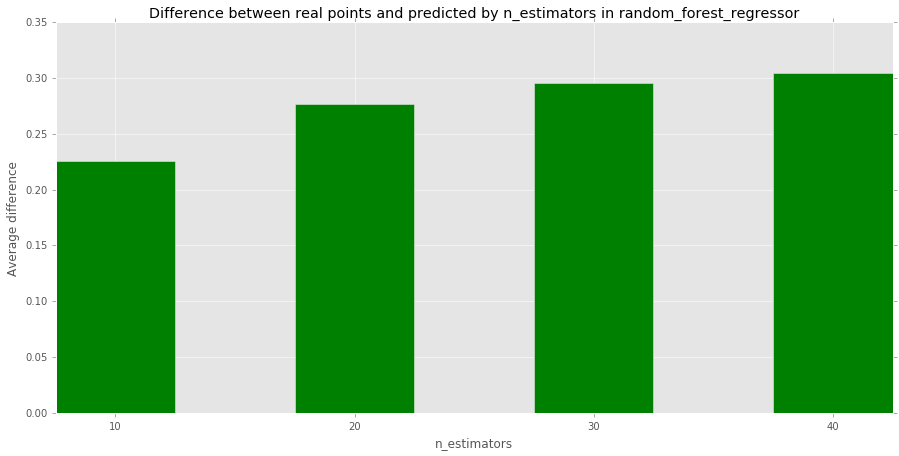

In [13]:
compare_results(function=random_forest_regressor, test_results=test_results, parameter_name="n_estimators",
                list_of_values=range(10, 50, 10), train_data=train_data, train_results=train_results,
                test_data=test_data)

1/4: 2016-11-03 17:31:11
2/4: 2016-11-03 17:32:51
3/4: 2016-11-03 17:36:08
4/4: 2016-11-03 17:41:06
done! 2016-11-03 17:47:39
Results: [-0.062454559419868882, 0.002574889752565257, 0.02070346234309961, 0.028876200785344475]


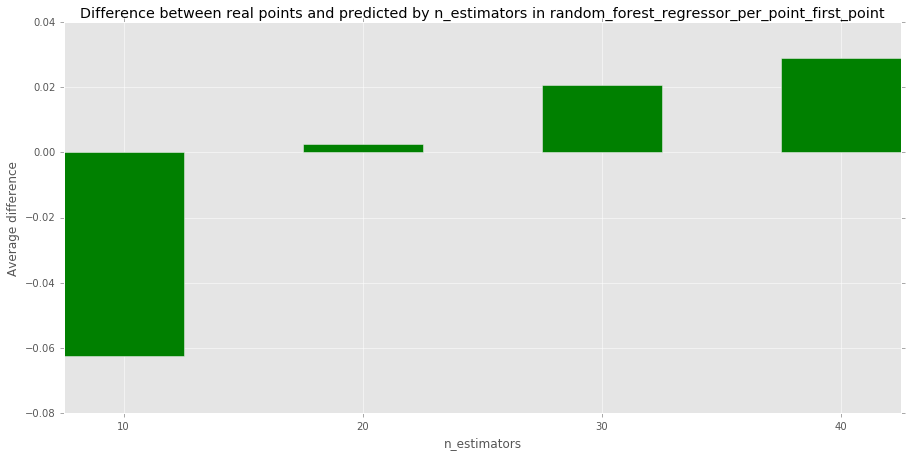

In [55]:
compare_results(function=random_forest_regressor_per_point_first_point, test_results=test_results,
                parameter_name="n_estimators", list_of_values=range(10, 50, 10),
                train_data=train_data, train_results=train_results, test_data=test_data)

1/3: 2016-11-03 18:25:00
2/3: 2016-11-03 18:43:23
3/3: 2016-11-03 19:12:40
done! 2016-11-03 19:48:54
Results: [0.031029090848869845, 0.041737783194354061, 0.053650427325691696]


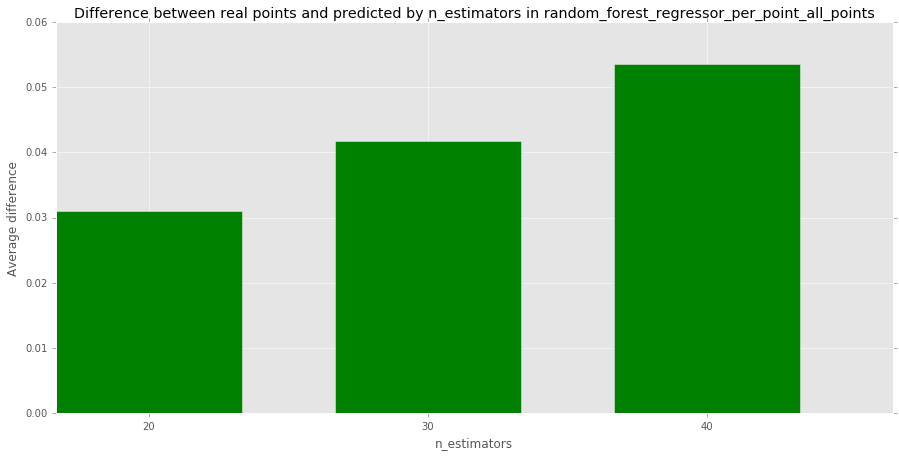

In [88]:
compare_results(function=random_forest_regressor_per_point_all_points, test_results=test_results,
                parameter_name="n_estimators", list_of_values=range(20, 50, 10),
                train_data=new_train_data, train_results=new_train_results, test_data=test_data)

In [15]:
def get_most_unpredictable_pedestrians(file, pedestrian_number):
    predicted = np.load(file)
    original = np.array(test_results)
    dist = distance_for_each_point(predicted, original)
    
    sum_dist = dist.sum(axis=0) 
    shuffled_indices = sum_dist.argsort()
    indices = shuffled_indices.copy()
    indices[::2] = np.minimum(shuffled_indices[::2], shuffled_indices[1::2])
    indices[1::2] = np.maximum(shuffled_indices[::2], shuffled_indices[1::2])
    
    for i in range(pedestrian_number):
        if i == 0:
            orig_path = original[:, indices[-2:]]
            pred_path = predicted[:, indices[-2:]]
        else:
            orig_path = original[:, indices[-2*(i+1):-2*i]]
            pred_path = predicted[:, indices[-2*(i+1):-2*i]]
        
        pedestrian, first_frame = find_by_path(orig_path)
        
        df = download_pedestrian(pedestrian)
        prev_path = np.array(df.loc[range(first_frame - 5 * 20, first_frame, 20)])
        draw_lines(frame_number=first_frame, paths=[prev_path, orig_path, pred_path], colors=['blue', 'green', 'red'],
           image_name="{ind}_ped{num}_frame{frame}".format(ind=i+1, num=pedestrian, frame=first_frame), draw_line=False)    

In [89]:
file = 'src/Logs/20161103_predicted_coordinates_random_forest_regressor_per_point_all_points_n_estimators_40.npy'
get_most_unpredictable_pedestrians(file=file, pedestrian_number=20)